In [30]:
from adjustText import adjust_text
from glob import glob
from scipy.stats import kendalltau, pearsonr
import geopandas as gpd
import json
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import warnings

from epitools import get_data

In [31]:
VOTES_POLLING = 100
RATE_THRESHOLD = 0.02
output = []

method = "nv"
for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    df_tmp = get_data(
        country="United States",
        aggregation="state",
        election="first_round",
        year=year
    )
    output.append(df_tmp)

df_epi = pd.concat(output, ignore_index=True)
df_epi.head()

,state,epi,epi_between,epi_within,year
0,ALABAMA,0.954538,0.812398,0.142140,2000
1,ALASKA,0.791327,0.648163,0.143164,2000
2,ARIZONA,0.969194,0.886976,0.082218,2000
3,ARKANSAS,0.992210,0.842943,0.149267,2000
4,CALIFORNIA,0.997502,0.782541,0.214961,2000


In [32]:
output = []
for file in glob("data_external/United States/ACSDT5Y*.B19083-*"):
    year = file[35:39]
    df_tmp = pd.read_csv(file)
    df_tmp["year"] = year
    output.append(df_tmp)

df = pd.concat(output, ignore_index=True)
df.head()

,Label (Grouping),Gini Index,year
0,Alabama,NaN,2010
1,Estimate,0.470,2010
2,Margin of Error,±0.003,2010
3,Alaska,NaN,2010
4,Estimate,0.412,2010


In [33]:
df_gini = pd.read_csv("data_curated/United States/Income_Inequality.csv")
df_gini.head()

,year,state,gini,moe
0,1917,UNITED STATES,0.507681,NaN
1,1917,ALABAMA,0.399792,NaN
2,1917,ARIZONA,0.399658,NaN
3,1917,ARKANSAS,0.376483,NaN
4,1917,CALIFORNIA,0.449363,NaN


In [34]:
output = []
method = "nv"

for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    df_tmp = get_data(
        country="United States",
        aggregation="state",
        election="first_round",
        year=year
    )
    output.append(df_tmp)

df_dv = pd.concat(output, ignore_index=True)
df_dv = df_dv.rename(columns={"epi": "value"})
df_dv["state"] = df_dv["state"].str.upper()

df_dv.head()

,state,value,epi_between,epi_within,year
0,ALABAMA,0.954538,0.812398,0.142140,2000
1,ALASKA,0.791327,0.648163,0.143164,2000
2,ARIZONA,0.969194,0.886976,0.082218,2000
3,ARKANSAS,0.992210,0.842943,0.149267,2000
4,CALIFORNIA,0.997502,0.782541,0.214961,2000


In [35]:
# API_DATA = "https://vibranium-api.datausa.io/cubes/acs_ygpsar_poverty_by_gender_age_race_5/aggregate.jsonrecords?drilldown[]=[Year].[Year]&drilldown[]=[Geography].[State].[State]&measures[]=Poverty+Rate&order=[Measures].[Poverty+Rate]&order_desc=true&nonempty=true&parents=true&sparse=true"
# r = requests.get(API_DATA).json()["data"]

# df_poverty = pd.DataFrame(r)
# df_poverty = df_poverty.rename(columns={
#     "State": "state",
#     "ID Year": "year",
#     "Poverty Rate": "poverty_rate"
# })
# df_poverty["state"] = df_poverty["state"].str.upper()
# df_poverty = df_poverty[["year", "state", "poverty_rate"]]
# df_poverty.loc[df_poverty["year"] == 2013, "year"] = 2012

# df_poverty.head()

In [36]:
# https://data.census.gov/cedsci/table?q=urban%20areas%20by%20state&tid=DECENNIALCD1132010.H2&tp=true
df_rurality = pd.read_csv("data_external/United States/DECENNIALCD1132010.H2-2022-11-02T160811.csv").dropna()
df_rurality = df_rurality.rename(columns={
    "Label (Grouping)": "state",
    "Total:!!Urban:": "urban",
    "Total:!!Rural": "rural"
})
df_rurality["state"] = df_rurality["state"].str.upper().str.replace(u"\xa0", "")
for col in ["urban", "rural"]:
    df_rurality[col] = df_rurality[col].str.replace(u"\u202f", "").astype(int)
df_rurality["rurality"] = df_rurality["rural"] / (df_rurality["urban"] + df_rurality["rural"])
# df_rurality = df_rurality[["state", "rurality"]]
df_rurality.head()

,state,Total:,urban,Total:!!Urban:!!Inside urbanized areas,Total:!!Urban:!!Inside urban clusters,rural,Total:!!Not defined for this file,rurality
1,ALABAMA,2 171 853 (r15032),1267224,1 040 659,226 565,904629,0.0,0.416524
3,ALASKA,306 967 (r15611),182989,123 286,59 703,123978,0.0,0.403881
5,ARIZONA,2 844 526,2515504,2 242 637,272 867,329022,0.0,0.115668
7,ARKANSAS,1 316 299 (r15934),720584,506 573,214 011,595715,0.0,0.452568
9,CALIFORNIA,13 680 081,12814688,12 051 891,762 797,865393,0.0,0.063259


In [37]:
df_affective = pd.read_csv("data_output/United States/Affective_Polarization_ANES.csv")
df_affective = df_affective[df_affective["type"] == "Affective"]
df_affective = df_affective.rename(columns={"value": "affective"})
df_affective.head()

,affective,year,N,type
2,29.412111,1980,NaN,Affective
5,32.956397,1982,NaN,Affective
8,31.840341,1984,NaN,Affective
11,31.428812,1986,NaN,Affective
14,33.641749,1988,NaN,Affective


In [38]:
df_political = pd.read_csv("data_output/United States/Political_Polarization_ANES.csv")
df_political.head()

,political,year
0,3.554328,2004
1,3.417359,2008
2,4.116796,2012
3,4.661368,2016
4,5.703792,2020


In [39]:
df_income1 = pd.read_csv(
    "https://www2.census.gov/programs-surveys/decennial/tables/time-series/historical-income-states/state1.csv",
    header=2
)
df_income1.columns = ["state", "1999", "1989_c", "1989", "1979_c", "1979", "1969_c", "1969"]
df_income1 = df_income1[2:].dropna()

for col in list(df_income1):
    df_income1[col] = df_income1[col].str.replace(",", "")

df_income1.head()

,state,1999,1989_c,1989,1979_c,1979,1969_c,1969
2,Alabama,34135,23597,30786,13669,29243,6419,25151
3,Alaska,51571,41408,54023,25414,54369,11817,46301
4,Arizona,40558,27540,35930,16448,35188,8199,32125
5,Arkansas,32182,21147,27589,12214,26130,5356,20986
6,California,47493,35798,46704,18243,39028,9302,36447


In [40]:
def clean_bea_data(
    PATH,
    value_name="value"
):
    tmp = pd.read_csv(PATH, header=3).dropna(subset=["GeoName"])
    tmp = tmp.melt(id_vars=["GeoFips", "GeoName"], var_name="year", value_name=value_name)
    tmp = tmp.rename(columns={"GeoFips": "state_id", "GeoName": "state"})
    tmp = tmp[~(tmp["state_id"].str[0] == "9")]
    tmp = tmp[tmp[value_name] != "(NA)"]
    tmp = tmp[tmp["state_id"] != "00000"]
    tmp["state"] = tmp["state"].replace({" *": ""}).str.upper()
    tmp = tmp.drop(columns=["state_id"])
    tmp[value_name] = tmp[value_name].astype(float)
    tmp["year"] = tmp["year"].astype(int)

    return tmp


In [41]:
def clean_shadac_data(
    PATH,
    value_name="value"
):
    tmp = pd.read_csv(PATH, header=4)
    tmp = tmp.rename(columns={"Location": "state", "TimeFrame": "year", "Data": value_name})
    tmp = tmp[["state", "year", value_name]]
    tmp = tmp[tmp["state"] != "United States"]
    tmp[value_name] = tmp[value_name].astype(float)
    tmp["state"] = tmp["state"].str.upper()

    return tmp

In [42]:
df_unemployment = clean_shadac_data(
    PATH = "data_external/United States/SHADAC_Unemployment.csv",
    value_name = "unemployment"
)
df_unemployment.head()

,state,year,unemployment
0,ALABAMA,2000,0.041
1,ALABAMA,2001,0.047
2,ALABAMA,2002,0.054
3,ALABAMA,2003,0.054
4,ALABAMA,2004,0.050


In [43]:
# df_gini = clean_shadac_data(
#     PATH = "data_external/United States/SHADAC_Inequality.csv",
#     value_name = "gini"
# )
# df_gini.head()

In [44]:
df_personal_income = clean_bea_data(
    PATH="data_external/United States/BEA_Personal_income.csv",
    value_name="personal_income"
)
df_personal_income.head()

,state,year,personal_income
1,ALABAMA,1929,319.0
3,ARIZONA,1929,598.0
4,ARKANSAS,1929,303.0
5,CALIFORNIA,1929,994.0
6,COLORADO,1929,631.0


In [45]:
df_population = clean_bea_data(
    PATH="data_external/United States/BEA_Population.csv",
    value_name="population"
)
df_population.head()

,state,year,population
1,ALABAMA,1929,2644000.0
3,ARIZONA,1929,430000.0
4,ARKANSAS,1929,1852000.0
5,CALIFORNIA,1929,5531000.0
6,COLORADO,1929,1008000.0


In [46]:
df_gdp = clean_bea_data(
    PATH="data_external/United States/BEA_Real_GDP.csv",
    value_name="gdp"
)
df_gdp.head()

,state,year,gdp
1,ALABAMA,1998,149568.2
2,ALASKA,1998,41095.9
3,ARIZONA,1998,183060.5
4,ARKANSAS,1998,84570.8
5,CALIFORNIA,1998,1468730.8


In [47]:
data = pd.merge(
    df_gini,
    df_dv,
    on=["state", "year"],
    how="outer"
)
data = data.rename(columns={
    "value": "epi"
})

# data = pd.merge(
#     data,
#     df_poverty,
#     on=["state", "year"],
#     how="outer"
# )

data = pd.merge(
    data,
    df_gdp,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_affective,
    on=["year"],
    how="outer"
)

# data = pd.merge(
#     data,
#     df_rurality,
#     on=["year", "state"],
#     how="outer"
# )

data = pd.merge(
    data,
    df_political,
    on=["year"],
    how="outer"
)

data = pd.merge(
    data,
    df_personal_income,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_unemployment,
    on=["state", "year"],
    how="outer"
)

data = pd.merge(
    data,
    df_population,
    on=["state", "year"],
    how="outer"
)

values = ["epi", "epi_between", "epi_within", "gini", "population"]
data[values] = data[values].astype(float)
data["affective"] = data["affective"] / 100
data = data.sort_values("year")
data = data[data["year"] > 1990]
data.head()

,year,state,gini,moe,epi,epi_between,epi_within,gdp,affective,N,type,political,personal_income,unemployment,population
3764,1991,UNITED STATES,0.574863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3794,1991,NEW HAMPSHIRE,0.551337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21436.0,NaN,1109929.0
3795,1991,NEW JERSEY,0.557374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25072.0,NaN,7814676.0
3767,1991,ARIZONA,0.580055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17731.0,NaN,3788576.0
5457,1991,ALASKA *,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23510.0,NaN,570193.0


In [48]:
# data[data["state"] == "FLORIDA"]

In [49]:
for measure in ["affective", "political", "gini", "epi", "epi_between", "epi_within", "personal_income", "population", "gdp", "unemployment"]:
    data[f"{measure}_1"] = data.dropna(subset=["epi"]).groupby("state")[measure].shift(periods=1)
    data[f"{measure}_g"] = (data[measure] - data[f"{measure}_1"])
    data[f"{measure}_r"] = (data[measure] - data[f"{measure}_1"]) / data[f"{measure}_1"]

pd.set_option('use_inf_as_na', True)
data.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)

In [50]:
data.dropna(subset=["epi"]).groupby("state")["gdp"].shift(periods=1).sum()

77023936.8

In [51]:
gdf = gpd.read_file(f"geo_shapes/composite_us_states.geojson")
gdf = gdf.rename(columns={"name": "state"})
gdf["state"] = gdf["state"].str.upper()

In [52]:
warnings.filterwarnings("ignore")
data1 = pd.merge(gdf, data)
for measure in ["affective", "political", "epi", "epi_between", "epi_within", "gini"]:
    output = []
    for year in data1.year.unique():
        
        data2 = data1[data1["year"] == year].copy()
        W = libpysal.weights.Queen.from_dataframe(data2)
        W.transform = "r"
    
        data2[f"sp_{measure}"] = libpysal.weights.lag_spatial(W, data2[measure])
        data2[f"sp_{measure}_1"] = libpysal.weights.lag_spatial(W, data2[f"{measure}_1"])
        data2["year"] = year
        data2[f"sp_{measure}_g"] = (data2[f"sp_{measure}"] - data2[f"sp_{measure}_1"])
        data2[f"sp_{measure}_r"] = (data2[f"sp_{measure}"] - data2[f"sp_{measure}_1"]) / data2[f"sp_{measure}_1"]

        output.append(data2[["year", "state", f"sp_{measure}", f"sp_{measure}_1", f"sp_{measure}_g", f"sp_{measure}_r"]])

    data1 = pd.merge(data1, pd.concat(output, ignore_index=True), on=["state", "year"])

data1 = data1.drop(columns=["geometry", "fips_state", "geo_id", "census_area", "iso_3166_2"])
data1.to_csv("data_regressions/United_States_sociodemographic.csv", index=False)

('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')


In [53]:
df_political.sort_values("political")

,political,year
1,3.417359,2008
0,3.554328,2004
2,4.116796,2012
3,4.661368,2016
4,5.703792,2020


In [119]:
data2 = data1[data1["year"] == 2020].copy()
data2 = pd.merge(
    data2,
    df_rurality,
    on=["state"],
    how="outer"
)

data2 = pd.merge(
    data2,
    df_poverty_2020,
    on=["state"],
    how="outer"
)
data2.head()

,state,lsad,census,pop_estimataes_base,pop_2010,pop_2011,pop_2012,pop_2013,pop_2014,year,...,sp_gini_g,sp_gini_r,Total:,urban,Total:!!Urban:!!Inside urbanized areas,Total:!!Urban:!!Inside urban clusters,rural,Total:!!Not defined for this file,rurality,poverty_rate
0,ARIZONA,,6392017.0,6392310.0,6411999.0,6472867.0,6556236.0,6634997.0,6731484.0,2020.0,...,0.001140,0.002478,2 844 526,2515504.0,2 242 637,272 867,329022.0,0.0,0.115668,12.8
1,ARKANSAS,,2915918.0,2915958.0,2922297.0,2938430.0,2949300.0,2958765.0,2966369.0,2020.0,...,0.001683,0.003535,1 316 299 (r15934),720584.0,506 573,214 011,595715.0,0.0,0.452568,15.2
2,CALIFORNIA,,37253956.0,37254503.0,37336011.0,37701901.0,38062780.0,38431393.0,38802500.0,2020.0,...,0.002067,0.004488,13 680 081,12814688.0,12 051 891,762 797,865393.0,0.0,0.063259,11.5
3,COLORADO,,5029196.0,5029324.0,5048575.0,5119661.0,5191709.0,5272086.0,5355866.0,2020.0,...,0.001486,0.003291,2 212 898,1838986.0,1 617 575,221 411,373912.0,0.0,0.168969,9.0
4,CONNECTICUT,,3574097.0,3574096.0,3579345.0,3590537.0,3594362.0,3599341.0,3596677.0,2020.0,...,-0.001733,-0.003546,1 487 891,1308541.0,1 259 361,49 180,179350.0,0.0,0.120540,9.7


In [118]:
df_poverty_2020 = pd.read_excel("data_external/United States/PovertyReport.xlsx", header=5)\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1).dropna()

df_poverty_2020 = df_poverty_2020[["Name", "Percent"]].rename(columns={"Name": "state", "Percent": "poverty_rate"})
df_poverty_2020["state"] = df_poverty_2020["state"].str.upper()

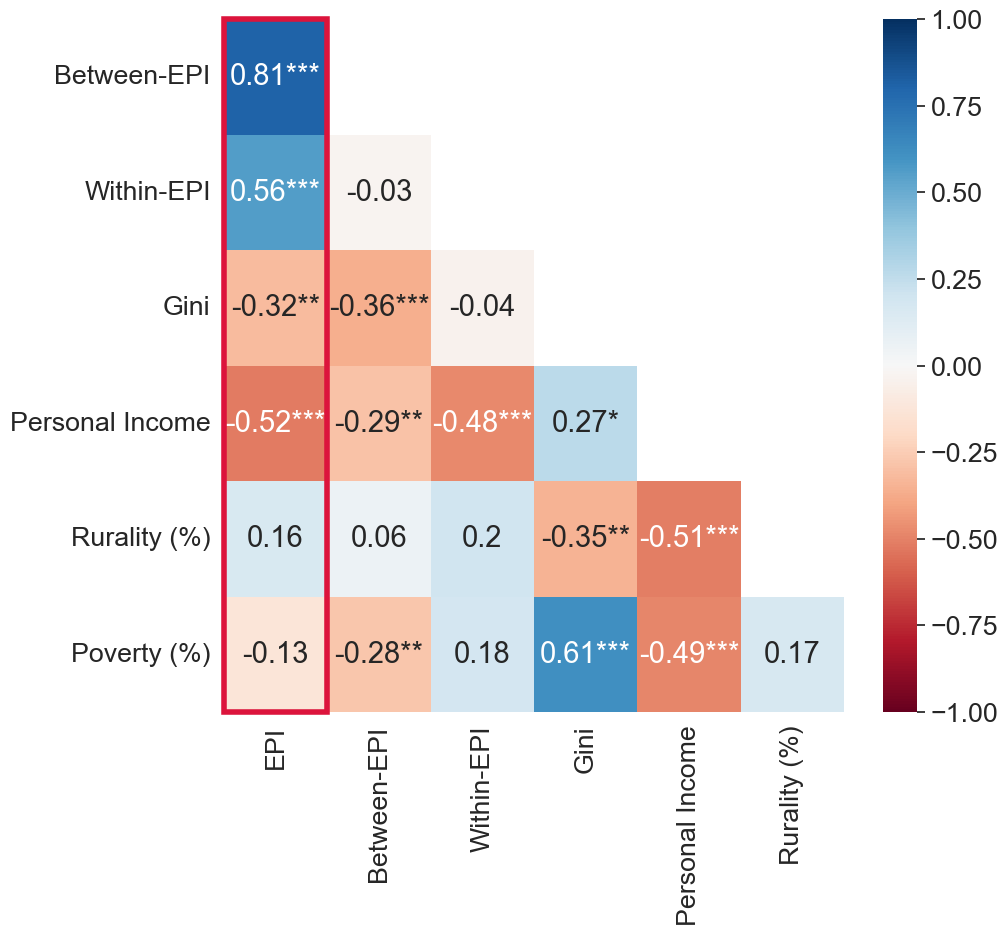

In [123]:
def set_corr(corr, _):
    corr = round(corr, 3)
    if _ < 0.01:
        return f"{corr}***"
    elif _ < 0.05:
        return f"{corr}**"
    elif _ < 0.1:
        return f"{corr}*"
    return corr

sns.set_style("whitegrid")
sns.set(font_scale=1.75, style="whitegrid")
matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rcParams['axes.grid'] = True

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

dd = data2[["epi", "epi_between", "epi_within", "gini", "personal_income", "rurality", "poverty_rate"]].copy() #, "household_income"
dd = dd.rename(columns={
    "epi": "EPI",
    "epi_between": "Between-EPI",
    "epi_within": "Within-EPI",
    "poverty_rate": "Poverty (%)",
    "gini": "Gini",
    "personal_income": "Personal Income",
    "rurality": "Rurality (%)"
})
# dd["Rurality (%)"] = dd["Rurality (%)"].astype(float)

corr_m = dd.corr()
rho = dd.corr()
pval = dd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
p = rho.round(2).astype(str) + p

p = np.tril(p.values, k=-1)

p[p==0] = np.nan
p = pd.DataFrame(p).dropna(axis=0, how="all").dropna(axis=1, how="all")
# print(p)
labels_m = list(corr_m)
corr_m = np.tril(corr_m.values, k=-1)

corr_m[corr_m==0] = np.nan

fig, ax = plt.subplots(figsize=(10, 9))

heatmap_data = pd.DataFrame(corr_m, index=labels_m, columns=labels_m).round(2)\
                .dropna(axis=0, how="all")\
                .dropna(axis=1, how="all")
#  
display()
g = sns.heatmap(heatmap_data, annot=p, vmin=-1, vmax=1, ax=ax, cmap="RdBu", fmt="", cbar=True)

g.set_ylim(heatmap_data.shape[0], 0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

from matplotlib.patches import Rectangle

wanted_label = 'Divisiveness'
wanted_index = 0 #labels.index(wanted_label)
N = len(list(heatmap_data))
x, y, w, h = 0, wanted_index, N, 1
for _ in range(1):
    g.add_patch(Rectangle((x, y), h, w, fill=False, edgecolor='crimson', lw=4, clip_on=False))

In [55]:
def normalize(col):
    x_min = col.min()
    x_max = col.max()
    x = col
    y = (x - x_min) / (x_max - x_min)
    return y

In [92]:
df_polarization = pd.merge(df_affective, df_epi_country, how="outer", on="year")
df_polarization = pd.merge(df_polarization, df_political, how="outer", on="year")
# df_polarization = df_polarization[df_polarization["year"] >= 2000]
df_polarization = df_polarization.sort_values("year")
df_polarization["affective"] = df_polarization["affective"] / 100
df_polarization["political"] = df_polarization["political"] / 10
for measure in ["affective", "value", "between", "within", "political"]:
    # df_polarization[measure] = normalize(df_polarization[measure])
    df_polarization[f"{measure}_1"] = df_polarization[measure].shift(periods=1)

df_pol_corr = df_polarization.copy()
df_polarization.head()
df_polarization = df_polarization.melt(id_vars=["year"], value_vars=["affective", "political", "value", "between", "within"])
df_polarization["variable"] = df_polarization["variable"].replace({
    "affective": "Affective",
    "political": "Political",
    "value": "Election",
    "between": "Between",
    "within": "Within"
})

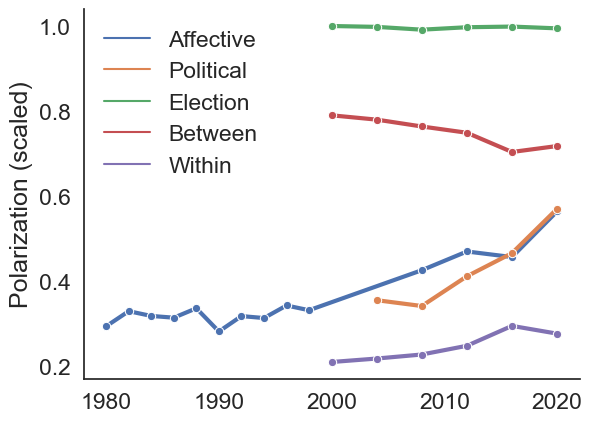

In [93]:
sns.set(font_scale=1.5, style="white")
g = sns.lineplot(x="year", y="value", marker="o", 
    hue="variable", lw=3, 
    data=df_polarization) #palette=["#DB2828", "#29AD02", "#240BED"], 
g.set_ylabel("Polarization (scaled)")
g.set_xlabel("")

plt.legend(title="", frameon=False)
sns.despine()

In [85]:
# df_pol_corr

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,nan,0,0,0,0,0,0,0,0,0,0,0
2,nan,nan,0,0,0,0,0,0,0,0,0,0
3,0.08,nan,nan,0,0,0,0,0,0,0,0,0
4,-0.49,nan,nan,0.14,0,0,0,0,0,0,0,0
5,0.46,nan,nan,-0.05,-1.0***,0,0,0,0,0,0,0
6,0.93*,nan,nan,0.11,-0.82*,0.81*,0,0,0,0,0,0
7,0.89***,nan,nan,-0.62,-0.98**,0.97**,0.54,0,0,0,0,0
8,0.24,nan,nan,-0.18,0.12,-0.13,0.03,0.88,0,0,0,0
9,-0.96**,nan,nan,0.07,0.79,-0.77,-0.98***,-0.45,-0.02,0,0,0


ValueError: `data` and `annot` must have same shape.

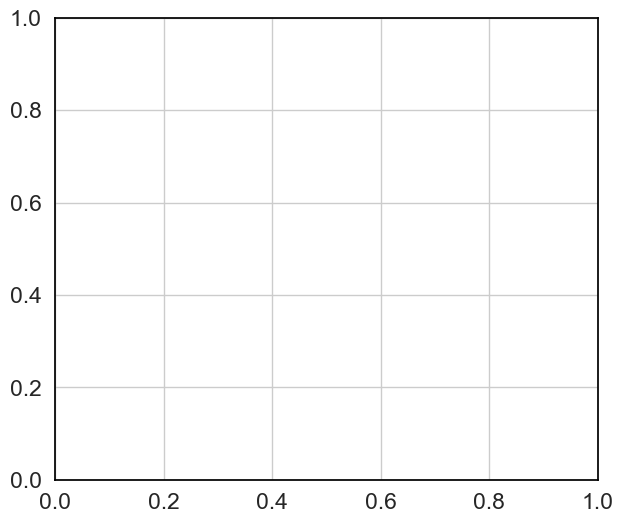

In [83]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5, style="whitegrid")
matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rcParams['axes.grid'] = True

items = {
    "value": "Election ($t$)",
    "value_1": "Election ($t - 1$)",
    "between": "Between ($t$)",
    "between_1": "Between ($t - 1$)",
    "within": "Within ($t$)",
    "within_1": "Within ($t - 1$)",
    "affective": "Affective ($t$)",
    "affective_1": "Affective ($t - 1$)",
    "political": "Political ($t$)",
    "political_1": "Political ($t - 1$)",
}
dd = df_pol_corr.copy()
dd = dd.drop(columns=["year"])
dd = dd.rename(columns=items)

corr_m = dd.corr()
rho = dd.corr()
pval = dd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
p = rho.round(2).astype(str) + p

p = np.tril(p.values, k=-1)

# p[p==0] = np.nan
p = pd.DataFrame(p).dropna(axis=0, how="all").dropna(axis=1, how="all")

labels_m = list(corr_m)
corr_m = np.tril(corr_m.values, k=-1)

corr_m[corr_m==0] = np.nan

fig, ax = plt.subplots(figsize=(7, 6))

heatmap_data = pd.DataFrame(corr_m, index=labels_m, columns=labels_m).round(2)\
                .dropna(axis=0, how="all")\
                .dropna(axis=1, how="all")
display(p)
g = sns.heatmap(heatmap_data, annot=p, ax=ax, cmap="cividis", fmt="", cbar=True)

g.set_ylim(heatmap_data.shape[0], 0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)